# Deep Segmentation for Taxiing Demo

In [3]:
# Load model in ONNX format
import onnx

# Load the ONNX model
model_onnx = onnx.load("deep_segmentation_for_taxiing.onnx")

# Check that the model is well formed
onnx.checker.check_model(model_onnx)

# Print a human readable representation of the graph
# onnx.helper.printable_graph(model_onnx.graph)

In [4]:
# Load the original raw image and its ground-truth annotation and made them numpy array
from PIL import Image
import numpy as np
import skimage.transform

im_orig= Image.open("data/original_raw_image.png")
im_gt = Image.open("data/ground-truth_image.png")
im_orig = np.array(im_orig)
im_gt = np.array(im_gt)
outputStride = 16

In [5]:
# Prepare the input as a pytorch tensor

m = [0.28677342, 0.32502555, 0.28378068]
v = [0.5502759, 0.44975982, 0.42085205]
im_orig = skimage.transform.resize(im_orig, [(im_orig.shape[0]//outputStride)*outputStride,\
                                    (im_orig.shape[1]//outputStride)*outputStride], order=1) * ((2 ** 8) - 1)
im_input = im_orig/255.
im_input = (im_input - m)/v;
im_input_tmp = np.transpose(im_input,(2,0,1))
im_input_tmp = np.array(im_input_tmp)[np.newaxis, :, :].astype(np.float32)
print('input image shape', im_input_tmp.shape)


/home/tim/miniconda3/envs/TIM_Caffe2_Python/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/tim/miniconda3/envs/TIM_Caffe2_Python/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


input image shape (1, 3, 1072, 1920)


In [6]:
# ...continuing from above
import caffe2.python.onnx.backend as backend
#import time

prepared_backend = backend.prepare(model_onnx, device="CUDA:0") # CUDA:0 or "CPU"
#start = time.time()
outputs = prepared_backend.run(im_input_tmp)
#end = time.time()



CUDA operators do not support 64-bit doubles, please use arr.astype(np.float32) or np.int32 for ints. Blob: 0 type: float64


In [7]:
print('output prediction shape', outputs[0].shape)


output prediction shape (1, 4, 67, 120)


In [8]:
# Get the output prediction image
import cv2 as cv

pred_tmp = np.transpose(outputs[0][0],(1,2,0))
pred = cv.resize(pred_tmp,(1920,1080), interpolation = cv.INTER_CUBIC)

#Compute arg-max to get final classes
pred = np.argmax(pred, axis=2)

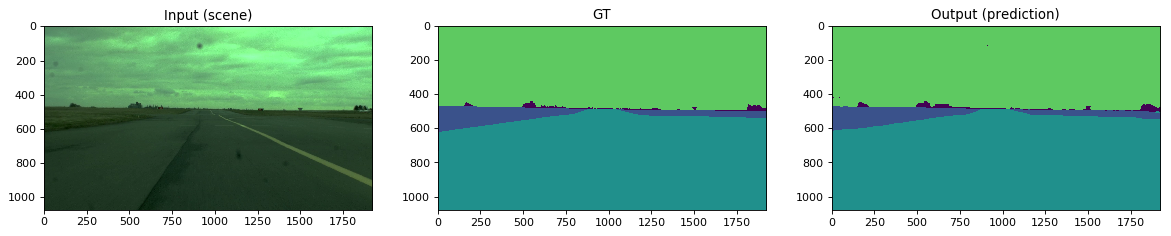

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(im_orig/255.)
ax.set_title("Input (scene)")

ax = plt.subplot("132")
ax.imshow(im_gt, vmin=0, vmax=4)
ax.set_title("GT")

ax = plt.subplot("133")
ax.imshow(pred, vmin=0, vmax=4) 
ax.set_title("Output (prediction)")
plt.show()